# Jupyter notebooks - hands on R

In [1]:
#setwd("/home/rok/dl/ektimo/")
require(randomForest)
require(dplyr)
require(magrittr)
require(ggplot2)

Loading required package: randomForest
randomForest 4.6-12
Type rfNews() to see new features/changes/bug fixes.
Loading required package: dplyr

Attaching package: ‘dplyr’

The following object is masked from ‘package:randomForest’:

    combine

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union

Loading required package: magrittr
Loading required package: ggplot2

Attaching package: ‘ggplot2’

The following object is masked from ‘package:randomForest’:

    margin



## Load data and check basic properties

In [2]:
#bank <- read.csv(file="bank-full.csv",header=TRUE,sep=";", stringsAsFactors=FALSE) %>% as.tbl
bank <- read.csv(file="BankData/bank-full.csv",header=TRUE,sep=";") %>% as.tbl
bank %<>% mutate(id=1:n())

#how many with "yes" response      
bank %>% group_by(y) %>% summarise(n())


,y,n()
1,no,39922
2,yes,5289


## Split the dataset in two sets - train and test

In [3]:
trainingData <- bank %>% group_by(y) %>% sample_frac(0.1) %>% ungroup()
head(trainingData)
trainingData %<>% select(y,duration,month,contact,poutcome,pdays,day,housing)
str(trainingData)
contactModel <- nrow(trainingData)
responseTrain <- sum(trainingData$y == "yes")

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y,id
1,31,self-employed,married,secondary,no,33,no,no,cellular,6,aug,165,4,-1,0,unknown,no,19323
2,58,blue-collar,married,secondary,no,1626,no,no,cellular,20,aug,391,4,-1,0,unknown,no,21842
3,32,technician,married,tertiary,no,43,no,no,cellular,22,aug,154,5,-1,0,unknown,no,22558
4,29,admin.,single,secondary,no,382,yes,no,unknown,12,may,460,1,-1,0,unknown,no,2206
5,53,unemployed,married,secondary,no,76,yes,yes,unknown,16,may,283,1,-1,0,unknown,no,3716
6,33,technician,married,secondary,no,153,yes,no,unknown,16,may,148,2,-1,0,unknown,no,3941


Classes ‘tbl_df’, ‘tbl’ and 'data.frame':	4521 obs. of  8 variables:
 $ y       : Factor w/ 2 levels "no","yes": 1 1 1 1 1 1 1 1 1 1 ...
 $ duration: int  165 391 154 460 283 148 401 283 231 59 ...
 $ month   : Factor w/ 12 levels "apr","aug","dec",..: 2 2 2 9 9 9 4 6 2 9 ...
 $ contact : Factor w/ 3 levels "cellular","telephone",..: 1 1 1 3 3 3 1 1 1 1 ...
 $ poutcome: Factor w/ 4 levels "failure","other",..: 4 4 4 4 4 4 4 4 4 4 ...
 $ pdays   : int  -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 ...
 $ day     : int  6 20 22 12 16 16 6 11 12 11 ...
 $ housing : Factor w/ 2 levels "no","yes": 1 1 1 2 2 2 1 2 1 2 ...


In [4]:
testData <- bank %>% filter(!id %in% trainingData$id) %>% 
    select(y,duration,month,contact,poutcome,pdays,day,housing,balance)
head(testData)

,y,duration,month,contact,poutcome,pdays,day,housing,balance
1,no,261,may,unknown,unknown,-1,5,yes,2143
2,no,151,may,unknown,unknown,-1,5,yes,29
3,no,76,may,unknown,unknown,-1,5,yes,2
4,no,92,may,unknown,unknown,-1,5,yes,1506
5,no,198,may,unknown,unknown,-1,5,no,1
6,no,139,may,unknown,unknown,-1,5,yes,231


## Train random forest model


Call:
 randomForest(formula = y ~ duration + month + contact + poutcome +      pdays + day + housing, data = trainingData, importance = TRUE) 
               Type of random forest: classification
                     Number of trees: 500
No. of variables tried at each split: 2

        OOB estimate of  error rate: 9.98%
Confusion matrix:
      no yes class.error
no  3876 116  0.02905812
yes  335 194  0.63327032

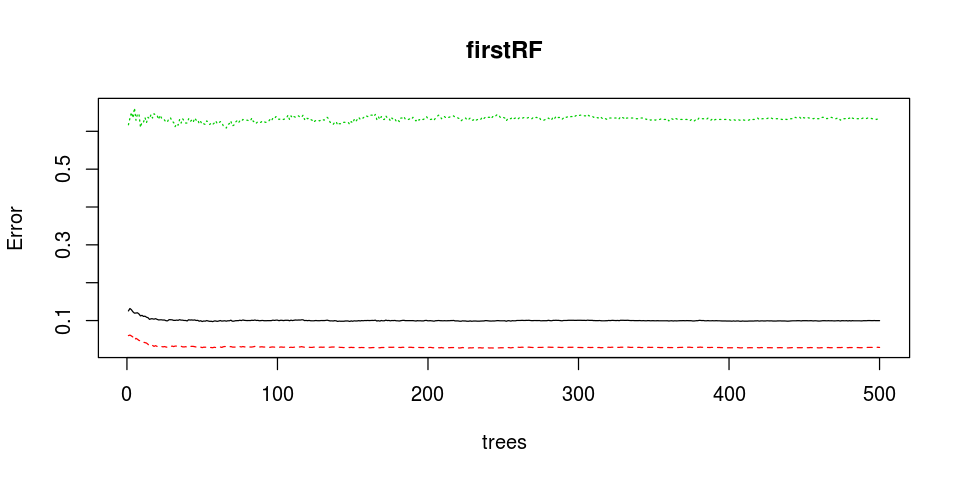

In [5]:
firstRF <- randomForest(y~duration+month+contact+poutcome+pdays+day+housing,data=trainingData,importance=TRUE)
testData %<>% mutate(predicted=predict(firstRF,.,type="prob")[,2]) %>%
	mutate(outcome=ifelse(y=="no", 0, 1))
firstRF

options(repr.plot.width=8, repr.plot.height=4)
plot(firstRF)

## Even though the results are not very accurate, we can try to sort predictions and compare it to random and balance order

In [6]:
randomContact <- testData %>% sample_frac(1) %>% select(outcome) %>% mutate(cumSum=cumsum(outcome), group="random", orderIndex=1:n())
balanceContact <- testData %>% arrange(desc(balance)) %>% select(outcome) %>% mutate(cumSum=cumsum(outcome), group="balance", orderIndex=1:n())
predictedContact <- testData %>% arrange(desc(predicted)) %>% select(outcome) %>% mutate(cumSum=cumsum(outcome), group="predicted", orderIndex=1:n())

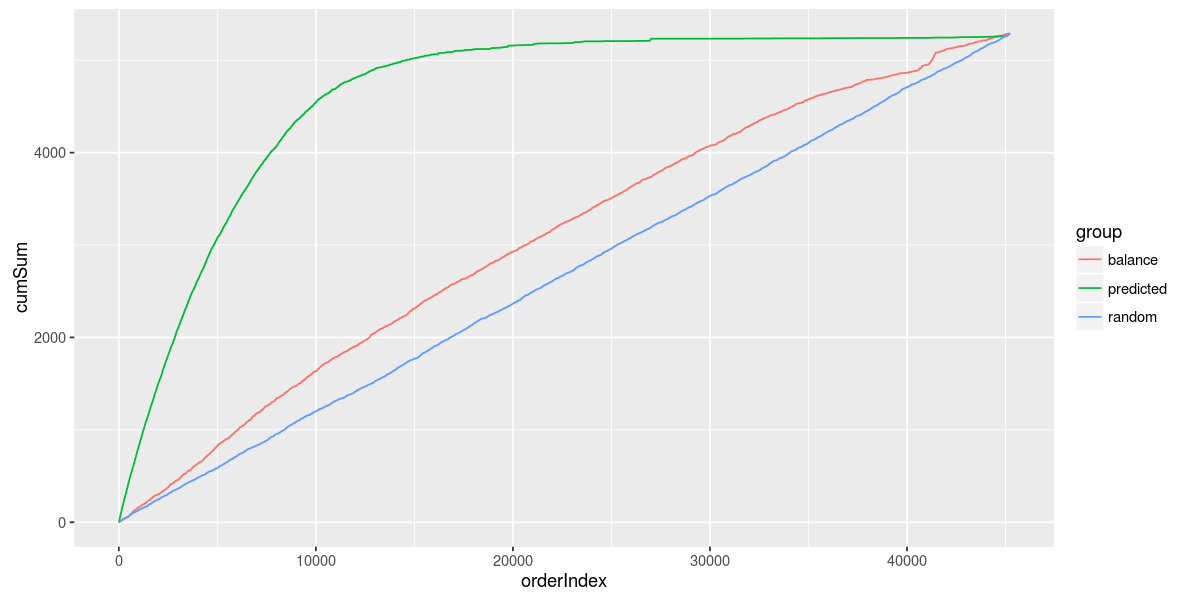

In [7]:
options(repr.plot.width=10, repr.plot.height=5)
randomContact %>% bind_rows(predictedContact) %>% bind_rows(balanceContact) %>%
	ggplot(data=., aes(orderIndex,cumSum)) + geom_line(aes(colour=group))

In [8]:
noContact <- 12000
result <- randomContact %>% slice(noContact) %>% summarize(type="random", contacted=orderIndex, responded=cumSum) %>% 
bind_rows(balanceContact %>% slice(noContact) %>% summarize(type="balance",contacted=orderIndex, responded=cumSum)) %>%
bind_rows(predictedContact %>% slice(noContact-contactModel) %>% summarize(type="model",contacted=orderIndex+contactModel, responded=cumSum+responseTrain))

In [9]:
result %>% mutate(improvment=responded/responded[1])

,type,contacted,responded,improvment
1,random,12000,1414,1
2,balance,12000,1906,1.347949
3,model,12000,4467,3.159123
